# Using APOC for object classification in google colab




## Getting a GPU

Before executing this notebook in google colab, please swith the runtime to `GPU`. From the menus at the top of the page, click on 'Runtime -> Change runtime type', select GPU and click on 'Save'. Then, at the top-right, click on 'Connect'.

<img src="https://github.com/BiAPoL/blog/raw/master/docs/robert_haase/clesperanto_google_colab/clesperanto_colab/colab2.png" width="500">

Additionally now, also at the top-right, you should see two very small graphs named  'RAM' and 'Disk'. Click on them to better visualize what computational resources are available for you.

## Installing additional packages

Google colab environment already comes with some popular scientific packages. In case you need to install extra packages to the environment, you can do so with `pip` as shown below.

**So, if running this from google colab**, execute the following line. It installs [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype#py-clesperanto), [apoc](https://github.com/haesleinhuepf/apoc#accelerated-pixel-and-object-classification-apoc) and [stackview](https://github.com/haesleinhuepf/stackview#stackview-) into your colab kernel.

In [ ]:
!pip install pyclesperanto_prototype apoc stackview ipycanvas==0.11


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.1/918.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:00
  Created wheel for transforms3d: filename=transforms3d-0.4.1-py3-none-any.whl size=1376772 sha256=bb97542ba57cf30f588d1f13ee80f35e0f7c3e829edd9308208bf9c2a770952e
  Stored in directory: /root/.cache/pip/wheels/06/37/d0/6e0fe02010be074e8138f2b5ffff5254b7475

## Importing packages

The next cell imports the necessary packages we use in this notebook and selects a specific backend for pyclesperanto. 

*Notice: due to a recent [opencl support on Google colab issue](https://github.com/clEsperanto/pyclesperanto_prototype/issues/300), it is necessary to change the backend to 'cupy' as done by running the cell below.*


In [ ]:
import apoc
import numpy as np
import pyclesperanto_prototype as cle
from skimage.io import imread
from skimage.data import human_mitosis
import stackview

cle.select_device("cupy")

'cupy backend (experimental)'

## Loading image
We will be using the `human_mitosis` example image from `scikit-image`.
We can load it and push it to the GPU as shown below.

/usr/local/lib/python3.10/dist-packages/pyclesperanto_prototype/_tier0/_cuda_backend.py:39: UserWarning: clesperanto's cupy / CUDA backend is experimental. Please use it with care. The following functions are known to cause issues in the CUDA backend:
affine_transform, apply_vector_field, create(uint64), create(int32), create(int64), resample, scale, spots_to_pointlist
  warnings.warn("clesperanto's cupy / CUDA backend is experimental. Please use it with care. The following functions are known to cause issues in the CUDA backend:\n" +


experimental clesperanto CUDAArray([[ 8.  8.  8. ... 63. 78. 75.]
 [ 8.  8.  7. ... 67. 71. 71.]
 [ 9.  8.  8. ... 53. 64. 66.]
 ...
 [ 8.  9.  8. ... 17. 24. 59.]
 [ 8.  8.  8. ... 17. 22. 55.]
 [ 8.  8.  8. ... 16. 18. 38.]], dtype=float32)
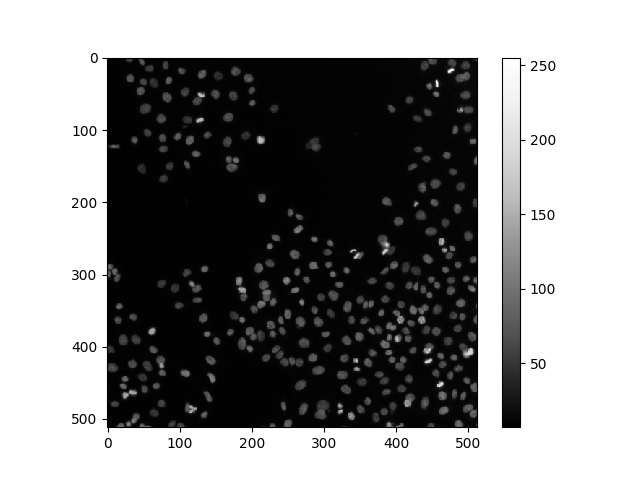
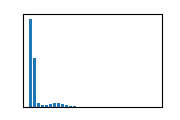

In [ ]:
image = cle.push(human_mitosis())
image

## Segmenting nuclei
We apply the [`voronoi_otsu_labeling`](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html#voronoi-otsu-labeling) function from `pyclesperanto` to segment the nuclei and generate a labeled image.

experimental clesperanto CUDAArray([[  0   0   0 ... 318 318 318]
 [  0   0   0 ... 318 318 318]
 [  0   0   0 ... 318 318 318]
 ...
 [  0   0   0 ...   0   0 324]
 [  0   0   0 ...   0   0 324]
 [  0   0   0 ...   0   0 324]], dtype=uint32)
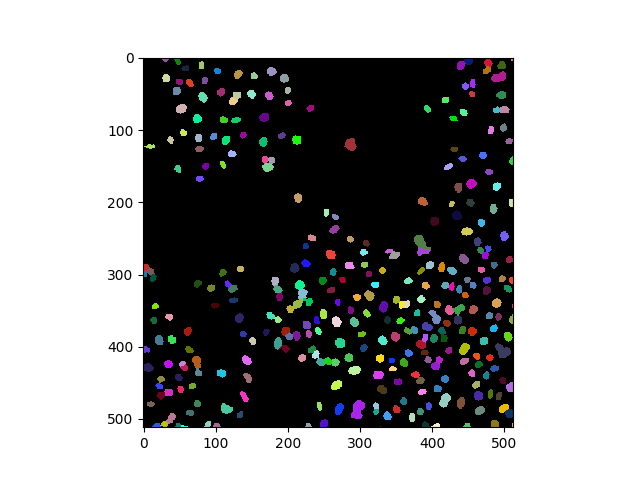

In [ ]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=2, outline_sigma=1)
labels

# Loading stored annotations
We read a labeled image containing annotations for the objects we segmented in order to classify them. 

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


In [ ]:
import stackview

In this example, we annotated three classes: 
1. brighter objects (blue), circular objects and elongated objects.
We use stackview to visualize both measurements together.

In [ ]:
stackview.curtain(np.asarray(image), np.asarray(labels), continuous_update=False, alpha=0.6)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
annotations = cle.push(imread('/content/gdrive/MyDrive/example_images/label_annotation.tif'))

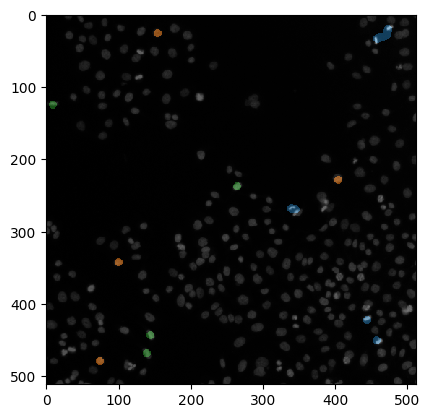

In [ ]:
cle.imshow(image, continue_drawing=True)
cle.imshow(annotations, labels=True, alpha=0.5)

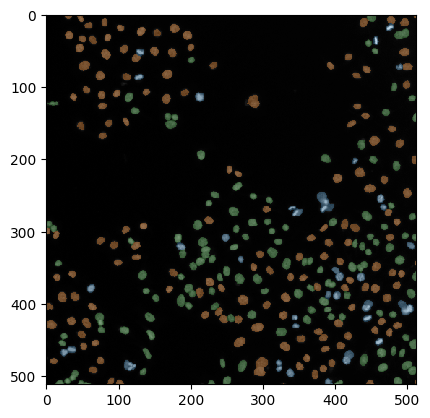

In [ ]:
features = 'area,min_intensity,max_intensity,standard_deviation_intensity,mean_intensity,mean_max_distance_to_centroid_ratio,max_distance_to_centroid'

# Create an object classifier
cl_filename_object_classifier = "gdrive/MyDrive/example_images/object_classifier.cl"
apoc.erase_classifier(cl_filename_object_classifier)
classifier = apoc.ObjectClassifier(cl_filename_object_classifier)

# train it
classifier.train(features, labels, annotations, image)

# determine object classification
classification_result = classifier.predict(labels, image)

cle.imshow(image, continue_drawing=True)
cle.imshow(classification_result, labels=True, alpha=0.3)

In [ ]:
classifier.train?